# Welfare Plots

This notebook plots the welfare distributions over model choice.

In [8]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.viz.plot_config import *

# Set data paths
PROJECT_ROOT = find_project_root()
RESULTS_PATH = f"{PROJECT_ROOT}/results/welfare"
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/welfare_plots"
ensure_dir_exists(PLOT_PATH)

# Seat of Power vs Rest of Pop

In [9]:
# Load dictionaires from file
data_store = {}
for calc in ["base", "imputed"]:
    data_store[calc] = {}
    for country in ["uk", "us"]:
        data_store[calc][country] = {}
        for mode in ["choice", "rating"]:
            data_store[calc][country][mode] = {}
            for group in ["_", "_nonmale_", "_nonwhite_", "_below_45_"]:
                if calc == "imputed":
                    path = (
                        f"{RESULTS_PATH}/welfare_{country}{group}{mode}_imputed.pickle"
                    )
                else:
                    path = f"{RESULTS_PATH}/welfare_{country}{group}{mode}.pickle"
                with open(path, "rb") as f:
                    loaded_data = pickle.load(f)
                    df = pd.DataFrame(loaded_data)
                    # Save
                    if group == "_":
                        group = "Rep"
                    elif group == "_nonmale_":
                        group = "Non-Male"
                    elif group == "_nonwhite_":
                        group = "Non-White"
                    elif group == "_below_45_":
                        group = "<45 Yrs"
                    data_store[calc][country][mode][group] = df

In [3]:
data_store["base"]["uk"]["choice"]["Rep"]

,uk_rep_10,uk_rep_20,uk_rep_50,uk_rep_100,uk_male_100,uk_white_100,uk_above_45_100
0,0.452991,0.452991,0.366463,0.465021,0.465021,0.465021,0.452991
1,0.341398,0.352321,0.465021,0.465021,0.465021,0.465021,0.465021
2,0.366463,0.452991,0.465021,0.465021,0.452991,0.452991,0.465021
3,0.298246,0.465021,0.352321,0.465021,0.465021,0.465021,0.352321
4,0.323045,0.465021,0.452991,0.465021,0.465021,0.465021,0.339394
...,...,...,...,...,...,...,...
995,0.250524,0.452991,0.298246,0.465021,0.452991,0.452991,0.465021
996,0.304167,0.323045,0.452991,0.452991,0.465021,0.465021,0.366463
997,0.304167,0.339394,0.452991,0.465021,0.465021,0.452991,0.250524
998,0.465021,0.452991,0.465021,0.452991,0.452991,0.452991,0.452991


### Get FOSD

In [10]:
def FOSD(list1, list2):
    """
    Returns true if list1 first order stochastically dominates
    """
    x = list1.sort()
    y = list2.sort()
    return all(x >= y for x, y in zip(list1, list2))


fosds = {}
for calc in ["base", "imputed"]:
    fosds[calc] = {}
    for country in ["uk", "us"]:
        fosds[calc][country] = {}
        for mode in ["choice", "rating"]:
            fosds[calc][country][mode] = {}
            for group in data_store[calc][country][mode]:
                fosds[calc][country][mode][group] = {}
                runs = data_store[calc][country][mode][group]
                for c in runs.columns:
                    if c == f"{country}_rep_100":
                        fosds[calc][country][mode][group][c] = np.nan
                    else:
                        fosds[calc][country][mode][group][c] = FOSD(
                            runs[f"{country}_rep_100"].to_list(), runs[c].to_list()
                        )

### Get Lims

In [11]:
lims = {}
for calc in ["base", "imputed"]:
    lims[calc] = {}
    for country in ["uk", "us"]:
        lims[calc][country] = {}
        n_outgroups = 0
        for mode in ["rating", "choice"]:
            all_values = []
            plot_data = data_store[calc][country][mode]
            for out_group, grp_data in plot_data.items():
                n_outgroups += 1
                data = grp_data.T
                for i, row in data.iterrows():
                    for per in [5, 25, 50, 75, 95]:
                        percentile = np.percentile(row, per)
                        all_values.append(percentile)
                        # Assign new column
                        data.loc[i, f"percentile_{per}"] = percentile
                    # Add mean and IQR
                    data.loc[i, "mean"] = np.mean(row)
                    data.loc[i, "quartile_25"] = np.percentile(row, 25)
                    data.loc[i, "quartile_75"] = np.percentile(row, 75)
                    data.loc[i, "iqr"] = np.percentile(row, 75) - np.percentile(row, 25)

                    data_store[calc][country][mode][out_group] = data

                lims[calc][country][mode] = {
                    "min": min(all_values),
                    "max": max(all_values),
                }

        print(lims)
        print(n_outgroups)

{'base': {'uk': {'rating': {'min': 56.81935483870968, 'max': 79.2037037037037}, 'choice': {'min': 0.17333333333333337, 'max': 0.5434782608695652}}}}
8
{'base': {'uk': {'rating': {'min': 56.81935483870968, 'max': 79.2037037037037}, 'choice': {'min': 0.17333333333333337, 'max': 0.5434782608695652}}, 'us': {'rating': {'min': 57.95121951219513, 'max': 75.12222222222222}, 'choice': {'min': 0.18055555555555555, 'max': 0.5166666666666667}}}}
8
{'base': {'uk': {'rating': {'min': 56.81935483870968, 'max': 79.2037037037037}, 'choice': {'min': 0.17333333333333337, 'max': 0.5434782608695652}}, 'us': {'rating': {'min': 57.95121951219513, 'max': 75.12222222222222}, 'choice': {'min': 0.18055555555555555, 'max': 0.5166666666666667}}}, 'imputed': {'uk': {'rating': {'min': 59.32653249592285, 'max': 77.91727414974596}, 'choice': {'min': 0.2277405409538394, 'max': 0.5153741222140149}}}}
8
{'base': {'uk': {'rating': {'min': 56.81935483870968, 'max': 79.2037037037037}, 'choice': {'min': 0.17333333333333337,

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_3600/1527873325.py:410: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


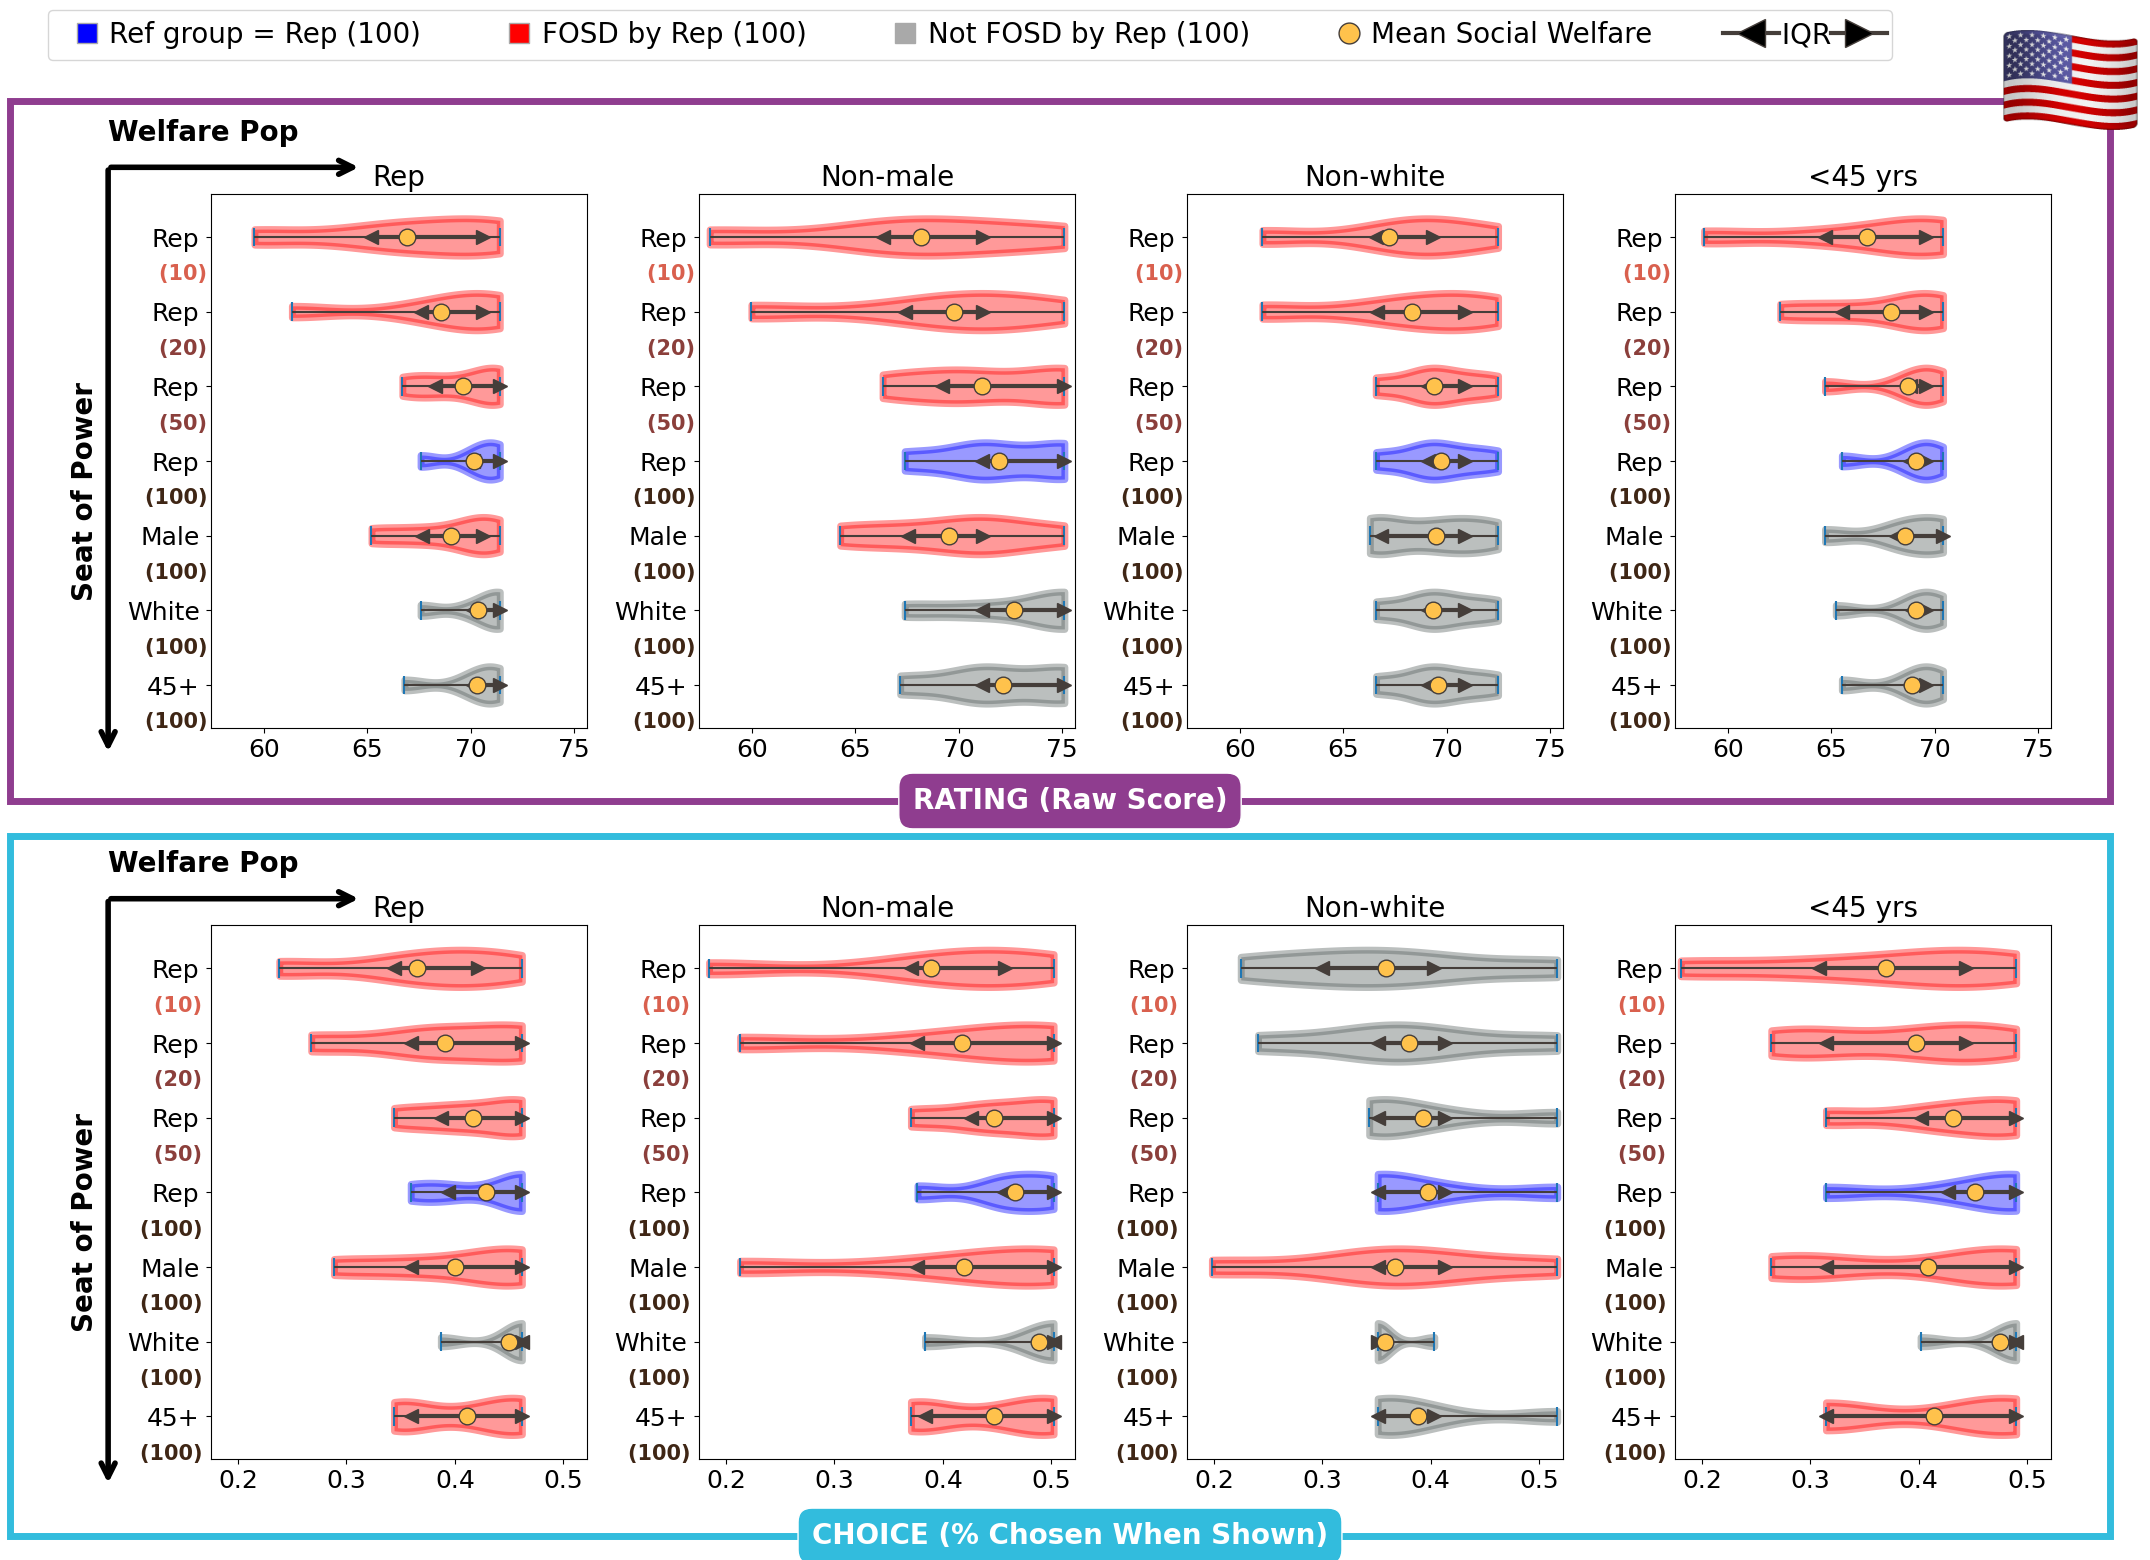

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_3600/1527873325.py:410: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


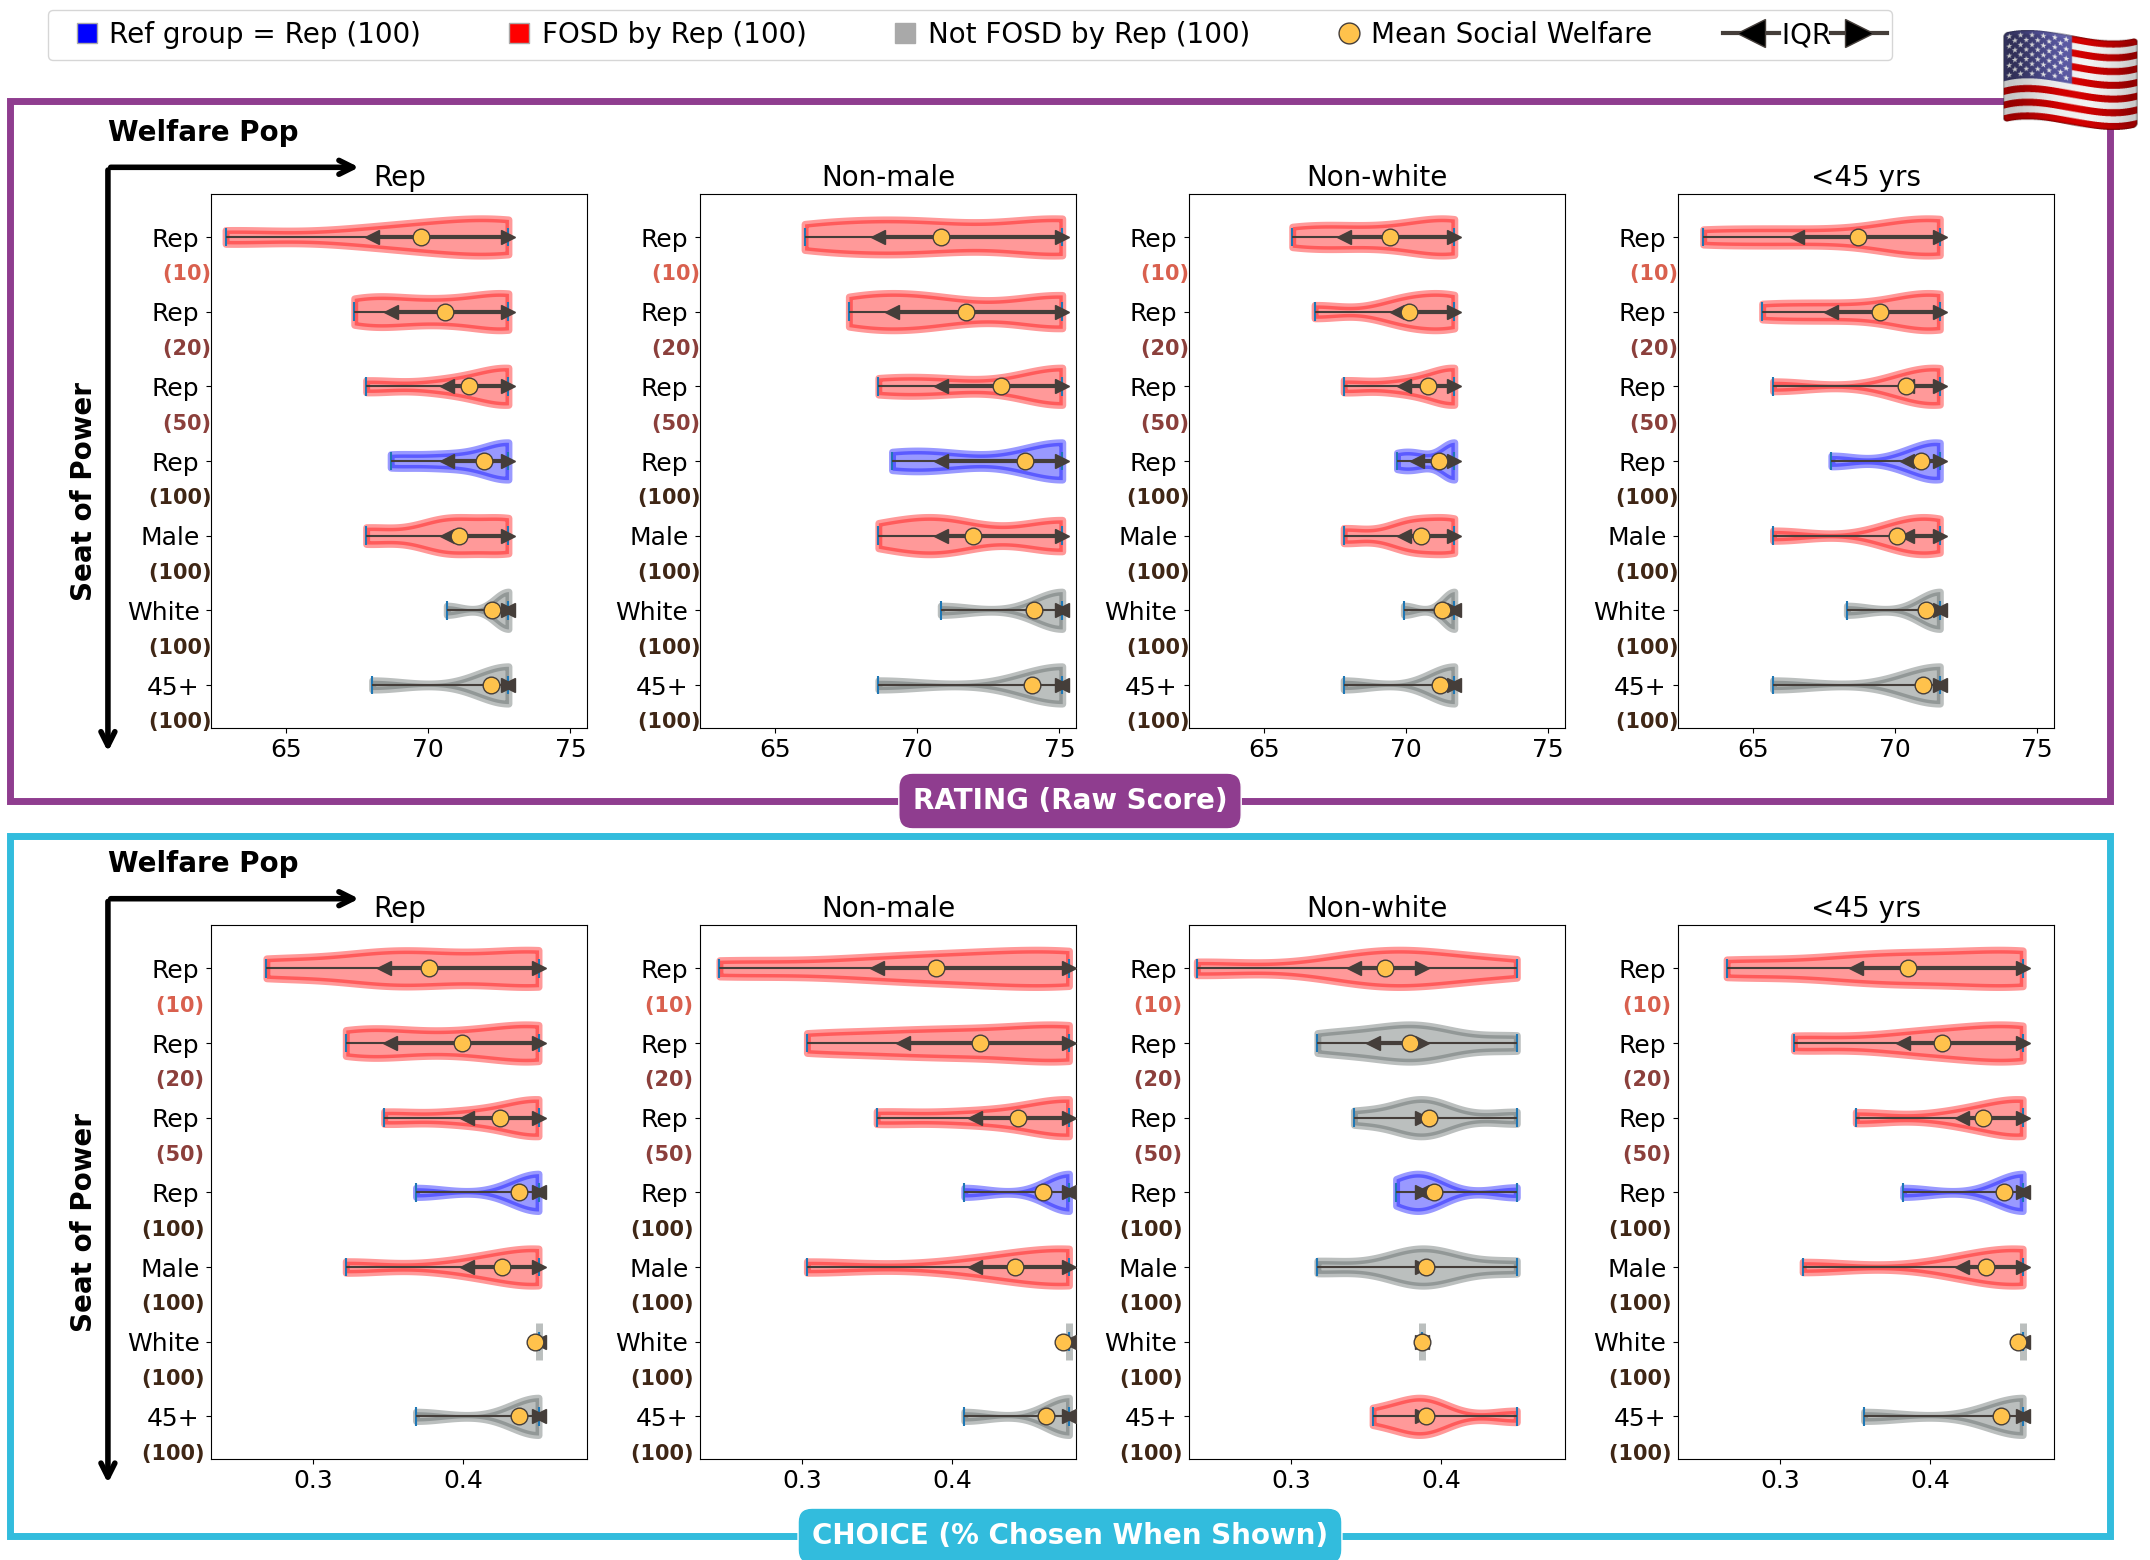

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_3600/1527873325.py:410: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


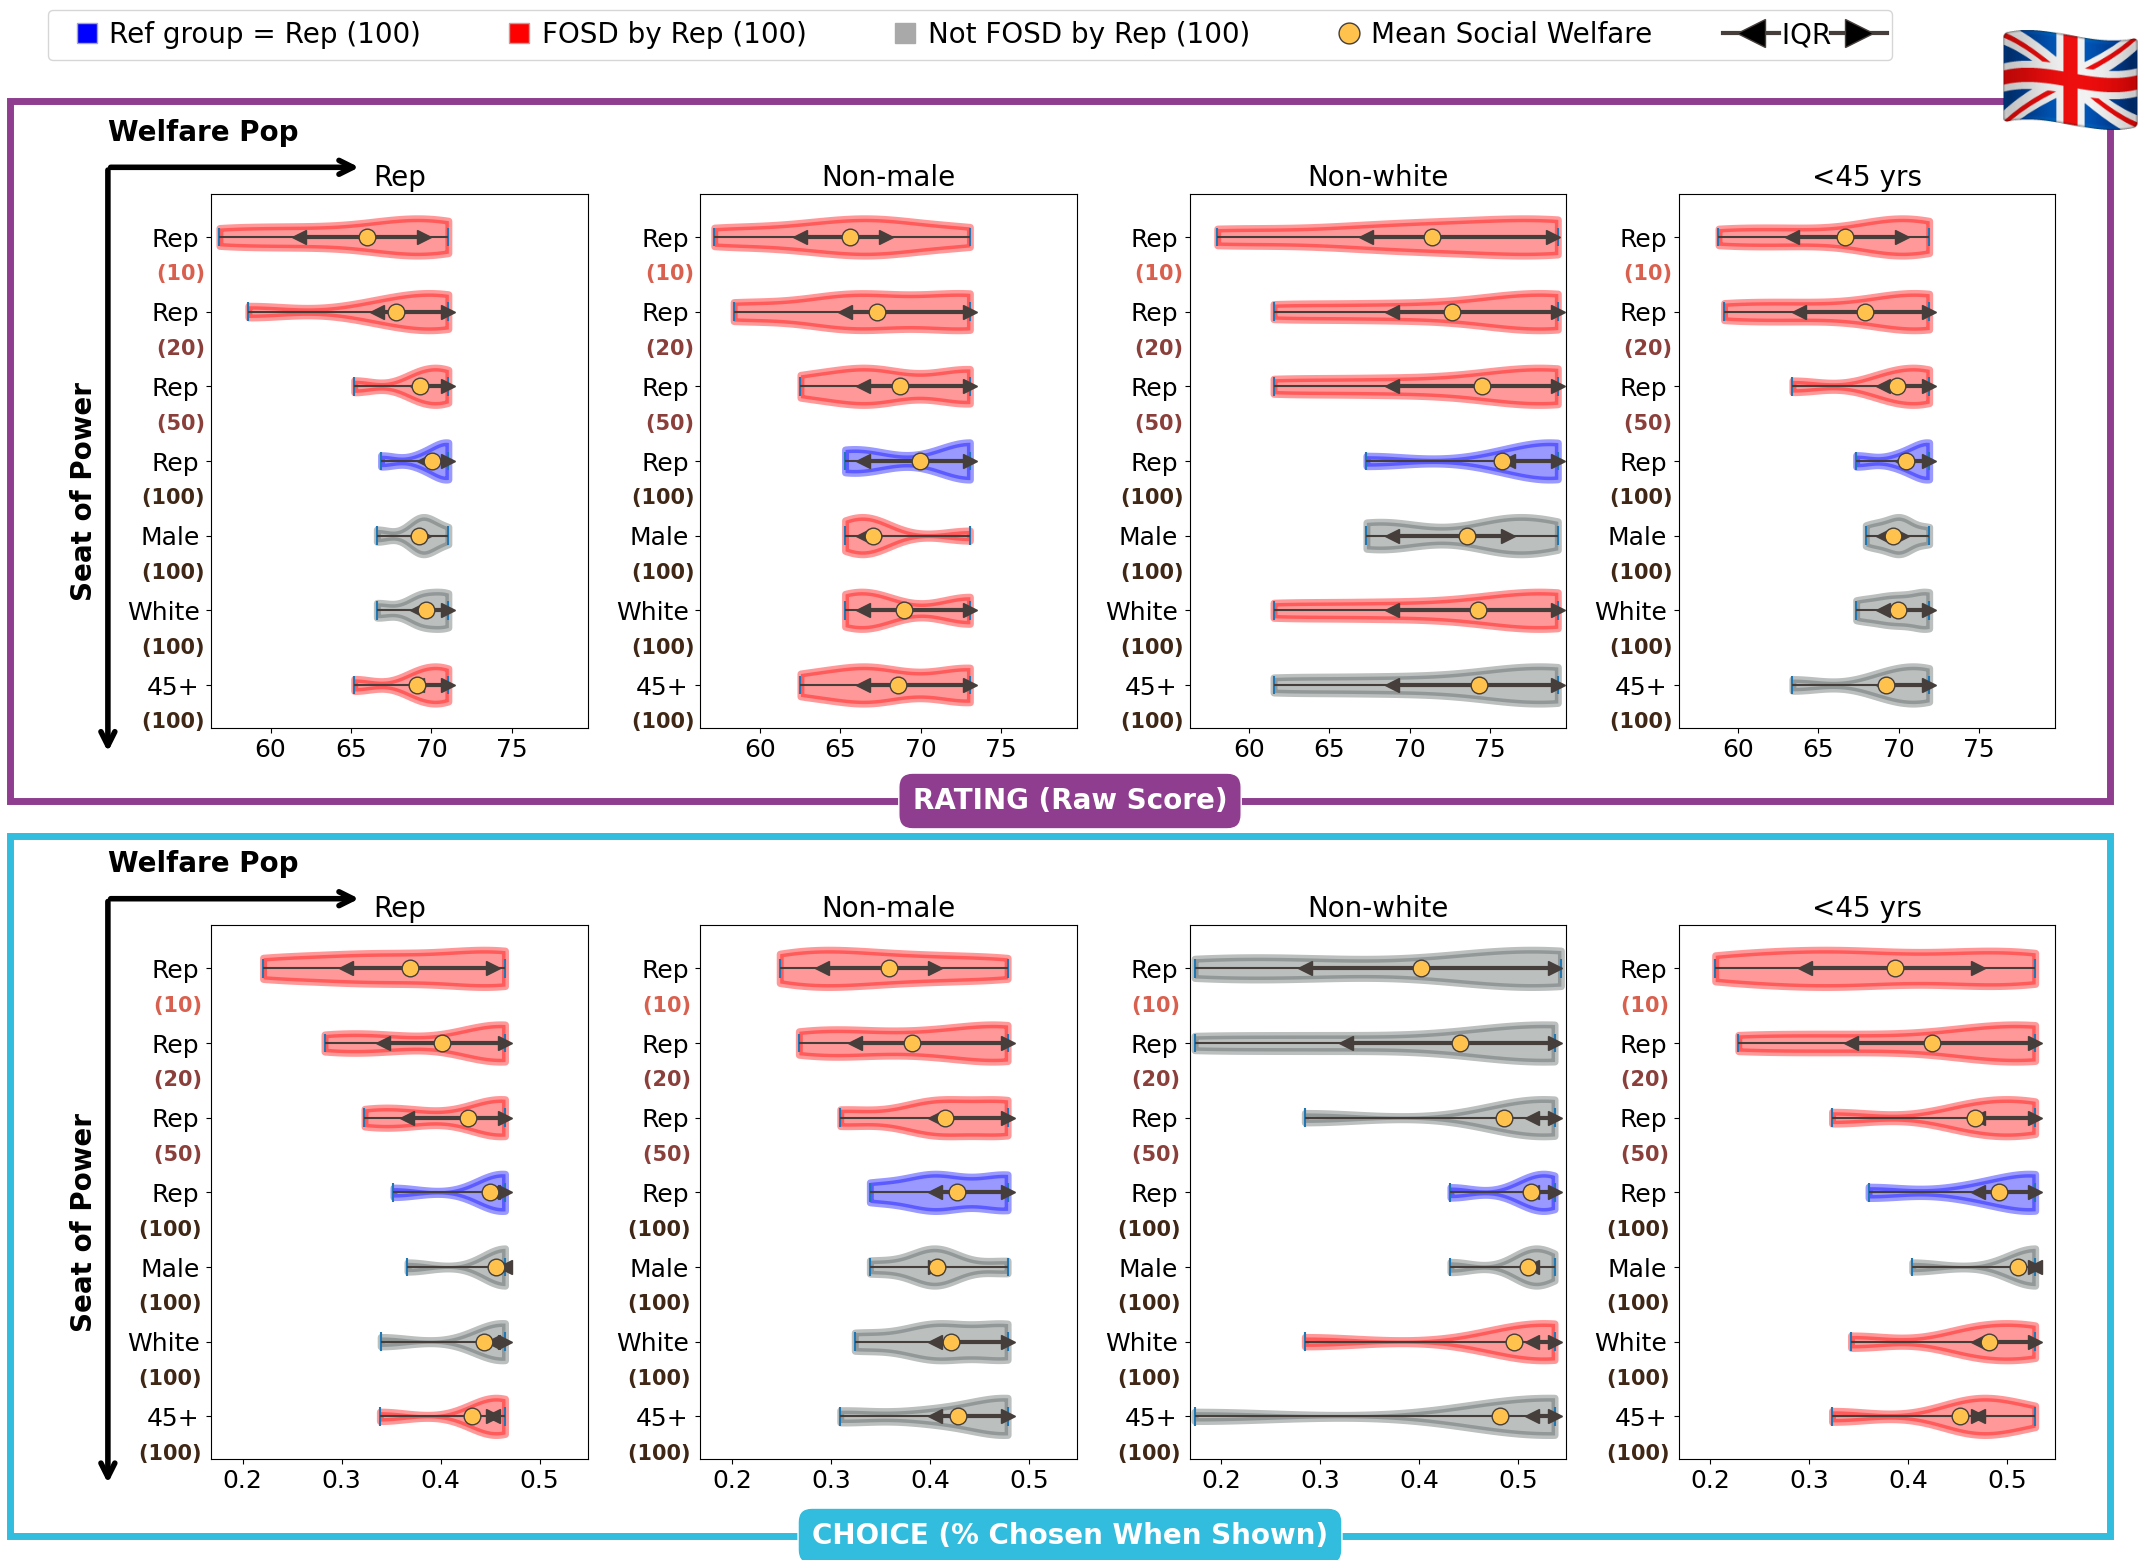

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_3600/1527873325.py:410: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


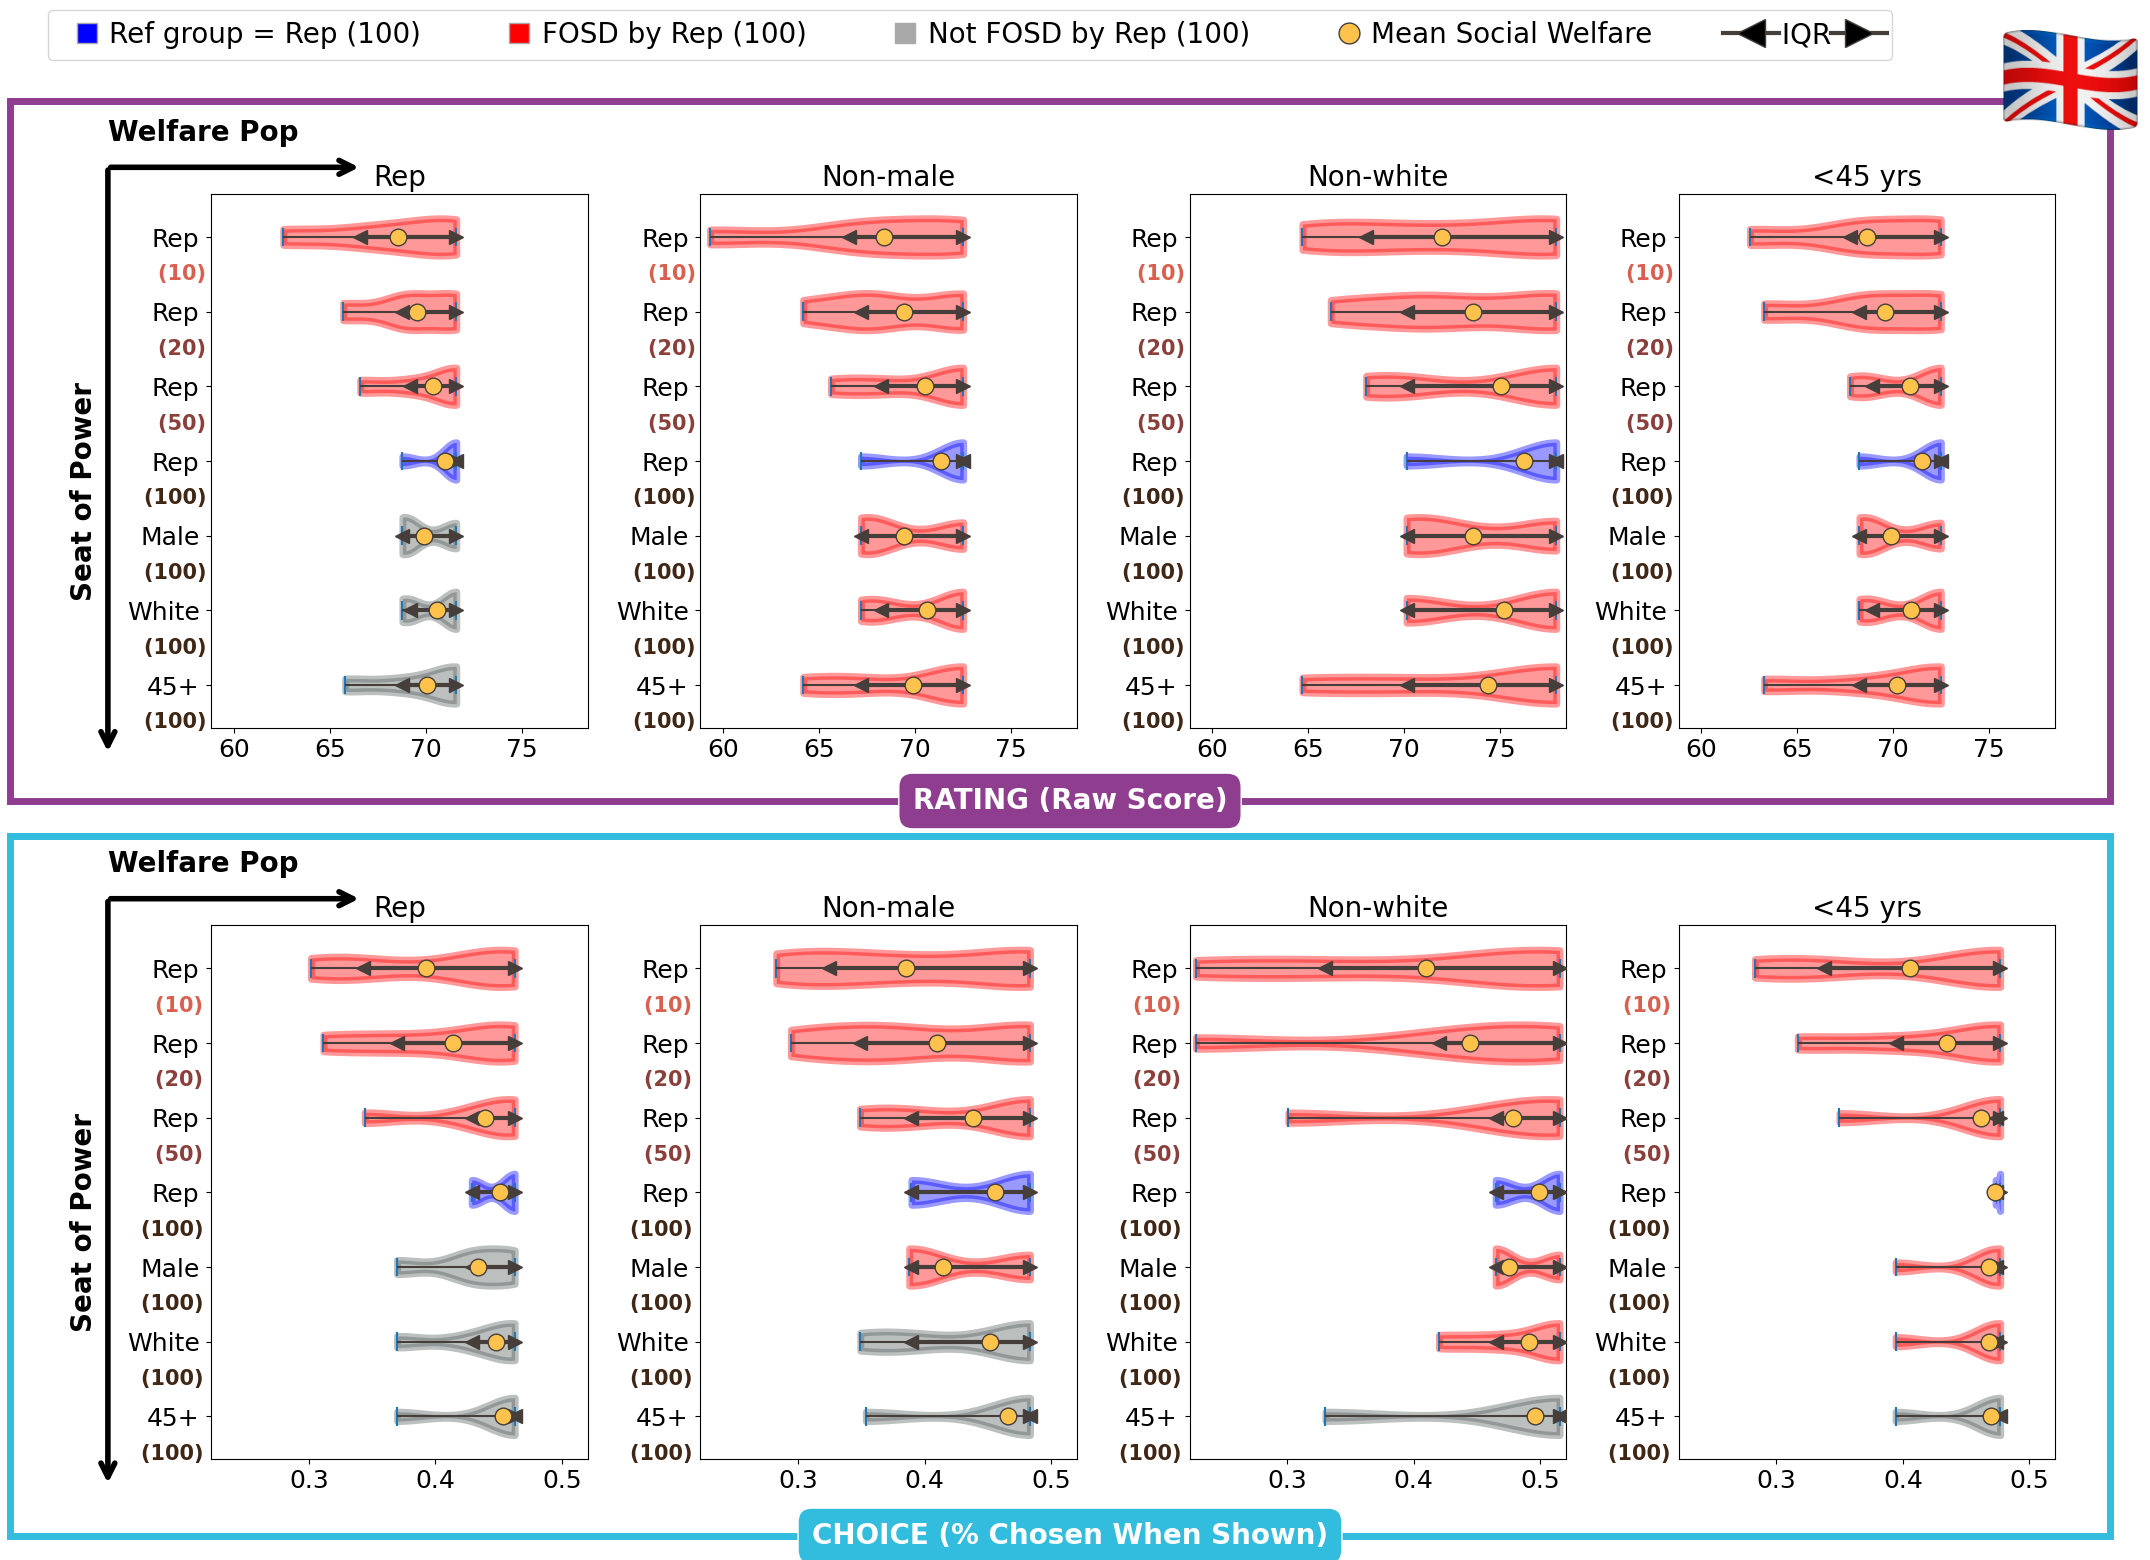

In [31]:
# Set up plots
for country in ["us", "uk"]:
    for calc in ["base", "imputed"]:
        if calc == "imputed":
            IMPUTED = True
        else:
            IMPUTED = False
        fig, ax = plt.subplots(2, 4, figsize=(20, 14))

        # Determins row
        for i, mode in enumerate(["rating", "choice"]):
            plot_data = data_store[calc][country][mode]
            for j, (out_group, grp_data) in enumerate(plot_data.items()):
                # This is now the column
                data = grp_data
                colors = get_equally_spaced_colors(
                    palettes_dict["batlow"].reversed(),
                    len(data.index),
                )
                all_cols = [str(c) for c in data.columns]
                percentile_cols = [col for col in all_cols if "percentile" in col]
                # Reverse order of index
                data = data.iloc[::-1]
                y_labels = data.index
                values = data[percentile_cols]
                violin_parts = ax[i, j].violinplot(
                    values.T,
                    positions=range(len(y_labels)),
                    bw_method=0.5,
                    vert=False,
                    showextrema=True,
                )
                # Set the color of the violin patches
                stat_colors = []
                get_fosd = fosds[calc][country][mode][out_group]

                # Set edge color to yellow if True
                def get_edge_color(fosd):
                    if fosd == True:
                        return "red"
                    elif fosd == False:
                        return "#565f5e"
                    else:
                        return "blue"

                fosd_edges = [get_edge_color(fosd) for fosd in get_fosd.values()]
                #
                # Reverse list
                fosd_edges = fosd_edges[::-1]

                for pc, color, edgecolor in zip(
                    violin_parts["bodies"], colors, fosd_edges
                ):
                    # pc.set_facecolor(color)
                    pc.set_facecolor(edgecolor)
                    pc.set_edgecolor(basic_colors_dict["darkgrey"])

                    pc.set_linewidth(5)
                    pc.set_alpha(0.4)
                    # If color of this violin is white, set edge color to dark grey
                    # edgecolor = basic_colors_dict["darkgrey"]
                    pc.set_edgecolor(edgecolor)
                    statcolor = (
                        basic_colors_dict["light_grey"]
                        if is_dark_color(color)
                        else basic_colors_dict["darkgrey"]
                    )
                    stat_colors.append(basic_colors_dict["darkgrey"])

                violin_parts["cbars"].set_colors([basic_colors_dict["darkgrey"]])

                # Plot a marker for the median, mean
                for y_pos, row in enumerate(data.iterrows()):
                    # Plot IQR
                    lq = row[1]["quartile_25"]
                    uq = row[1]["quartile_75"]
                    for q, marker in zip([lq, uq], ["<", ">"]):
                        ax[i, j].plot(
                            q,
                            y_pos,
                            marker=marker,
                            markersize=10,
                            markeredgecolor=stat_colors[y_pos],
                            zorder=10,
                            color=stat_colors[y_pos],
                        )
                    # Plot line between
                    ax[i, j].plot(
                        [lq, uq],
                        [y_pos, y_pos],
                        color=stat_colors[y_pos],
                        linewidth=3,
                        zorder=10,
                    )

                    median = row[1]["percentile_50"]
                    mean = row[1]["mean"]
                    ax[i, j].plot(
                        mean,
                        y_pos,
                        marker="o",
                        markersize=12,
                        label="Mean Social Welfare",
                        zorder=10,
                        color=basic_colors_dict["yellow"],
                        # Set edge color for marker
                        markeredgecolor=basic_colors_dict["darkgrey"],
                    )
                    # mean = row[1]["mean"]
                    # ax[i, j].plot(
                    #     mean,
                    #     y_pos,
                    #     marker="s",
                    #     markersize=12,
                    #     markeredgecolor=basic_colors_dict['darkgrey'],
                    #     color=basic_colors_dict['red'],
                    #     label = 'Mean Social Welfare',
                    #     zorder=10,
                    # )

                # Set column labels
                ax[i, j].set_title(f"{out_group.capitalize()}", fontsize=20)
                ax[i, j].set_ylabel("Seat of Power")
                # Increase x tick label siz
                ax[i, j].tick_params(axis="x", which="major", labelsize=18)
                # Set row labels
                if j == 0:
                    ax[i, j].set_ylabel(f"")
                    ax[i, j].set_xlim(
                        [
                            lims[calc][country][mode]["min"] - 0.5,
                            lims[calc][country][mode]["max"] + 0.5,
                        ]
                    )
                else:
                    ax[i, j].set_ylabel("")
                    ax[i, j].set_xlim(
                        [
                            lims[calc][country][mode]["min"] - 0.005,
                            lims[calc][country][mode]["max"] + 0.005,
                        ]
                    )

                # Fix Y labels
                clean_labels = []
                ns = []
                for yl in y_labels:
                    splits = yl.split("_")
                    country = splits[0]
                    n = splits[-1]
                    frame = (" ").join(splits[1:-1])
                    clean_label = f"{frame.capitalize()}"
                    if clean_label == "Above 45":
                        clean_label = "45+"
                    clean_labels.append(clean_label)
                    ns.append(int(n))

                # Set clean labels as y ticks
                ax[i, j].set_yticks(range(len(y_labels)), clean_labels, fontsize=18)
                ax[i, j].tick_params(axis="y", which="major", pad=5)
                if j == 0:
                    # Get edge of plot
                    x_pos = lims[calc][country][mode]["min"]
                else:
                    x_pos = lims[calc][country][mode]["min"]
                #
                label_colors = get_equally_spaced_colors(palettes_dict["lajolla"], 5)
                for y_pos, n in enumerate(ns):
                    if n == 100:
                        color = label_colors[0]
                    elif n == 50:
                        color = label_colors[1]
                    elif n == 10:
                        color = label_colors[2]
                    ax[i, j].text(
                        x_pos,
                        y_pos - 0.5,
                        f"({n})  ",
                        horizontalalignment="right",
                        verticalalignment="center",
                        fontsize=15,
                        color=color,
                        fontweight="semibold",
                    )

            # Fix X labels
            for k in range(4):
                ax[0, k].set_xlabel("", fontsize=20)
                ax[0, k].set_xlim(
                    [
                        lims[calc][country]["rating"]["min"] - 0.5,
                        lims[calc][country]["rating"]["max"] + 0.5,
                    ]
                )

                ax[1, k].set_xlabel("", fontsize=20)
                ax[1, k].set_xlim(
                    [
                        lims[calc][country]["choice"]["min"] - 0.005,
                        lims[calc][country]["choice"]["max"] + 0.005,
                    ]
                )

        # Create fake legend
        fake_legend = [
            # Add rectangles for FOSD
            plt.Line2D(
                [0],
                [0],
                marker="s",
                color="w",
                label=f"Ref group = Rep (100)        ",
                markerfacecolor="blue",
                markeredgecolor="darkgrey",
                markersize=15,
            ),
            plt.Line2D(
                [0],
                [0],
                marker="s",
                color="w",
                label=f"FOSD by Rep (100)        ",
                markerfacecolor="red",
                markeredgecolor="darkgrey",
                markersize=15,
            ),
            plt.Line2D(
                [0],
                [0],
                marker="s",
                color="w",
                label=f"Not FOSD by Rep (100)        ",
                markerfacecolor="darkgrey",
                markeredgecolor="darkgrey",
                markersize=15,
            ),
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label="Mean Social Welfare        ",
                markerfacecolor=basic_colors_dict["yellow"],
                markeredgecolor=basic_colors_dict["darkgrey"],
                markersize=15,
            ),
            plt.Line2D(
                [0],
                [0],
                marker="<",
                color=basic_colors_dict["darkgrey"],
                label=" IQR",
                markerfacecolor="black",
                markersize=20,
                linewidth=3,
            ),
            plt.Line2D(
                [0],
                [0],
                marker=">",
                color=basic_colors_dict["darkgrey"],
                label="",
                markerfacecolor="black",
                markersize=20,
                linewidth=3,
            ),
        ]

        ### RECT: RATING ###
        left_corner_x = -0.03
        width = 1.05
        height = 0.5
        y_bot = 0.505

        rect = plt.Rectangle(
            # (lower-left corner), width, height
            (left_corner_x, y_bot),
            width,
            height,
            fill=False,
            color="#8f3d8f",
            lw=5,
            zorder=1000,
            transform=fig.transFigure,
            figure=fig,
        )
        fig.patches.extend([rect])
        fig.text(
            0.5,
            y_bot,
            f"RATING (Raw Score)",
            ha="center",
            va="center",
            color="white",
            fontsize=20,
            weight="semibold",
            bbox=dict(
                facecolor="#8f3d8f",
                edgecolor="white",
                boxstyle="round,pad=0.5",
            ),
            transform=fig.transFigure,
            zorder=1001,
        )

        ### RECT: CHOICE ###
        y_bot = -0.02
        rect = plt.Rectangle(
            # (lower-left corner), width, height
            (left_corner_x, y_bot),
            width,
            height,
            fill=False,
            color=basic_colors_dict["blue"],
            lw=5,
            zorder=1000,
            transform=fig.transFigure,
            figure=fig,
        )

        fig.patches.extend([rect])

        fig.text(
            0.5,
            y_bot,
            f"CHOICE (% Chosen When Shown)",
            ha="center",
            va="center",
            color="white",
            fontsize=20,
            weight="semibold",
            bbox=dict(
                facecolor=basic_colors_dict["blue"],
                edgecolor="white",
                boxstyle="round,pad=0.5",
            ),
            transform=fig.transFigure,
            zorder=1001,
        )

        #### ARROWS ####
        for i in range(2):
            x_start = -0.275
            y_end = -0.05
            y_start = 1.05
            x_end = 0.4
            ax[i, 0].annotate(
                "",
                xy=(x_end, y_start),
                xycoords="axes fraction",
                xytext=(x_start, y_start),
                arrowprops=dict(
                    arrowstyle="->, head_width=0.5, head_length=1", color="black", lw=4
                ),
            )

            # Add text
            ax[i, 0].text(
                x_start,
                1.1,
                "Welfare Pop",
                fontsize=20,
                weight="semibold",
                transform=ax[i, 0].transAxes,
            )

            ax[i, 0].annotate(
                "",
                xy=(x_start, y_end),
                xycoords="axes fraction",
                xytext=(x_start, y_start),
                arrowprops=dict(
                    arrowstyle="->, head_width=0.5, head_length=1", color="black", lw=4
                ),
            )

            # Add text
            ax[i, 0].text(
                x_start - 0.1,
                0.25,
                "Seat of Power",
                fontsize=20,
                weight="semibold",
                rotation=90,
                transform=ax[i, 0].transAxes,
            )

        # Add legend
        fig.legend(
            handles=fake_legend,
            loc="upper center",
            ncol=6,
            fontsize=20,
            bbox_to_anchor=(0.45, 1.08),
            handletextpad=-0.2,
            columnspacing=-0,
            frameon=True,
        )

        ## Add US flag to the top right corner
        flag_ax = fig.add_axes(
            [0.95, 0.97, 0.1, 0.1]
        )  # x, y, width, height relative to figure
        flag_ax.imshow(
            plt.imread(f"{PLOT_PATH}/{country}-flag.png"), zorder=2000
        )  # Ensure 'us_flag.png' is the path to your image
        flag_ax.axis("off")
        flag_ax.set_zorder(10000)

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.37, wspace=0.3)
        # Save
        if IMPUTED:
            plt.savefig(
                f"{PLOT_PATH}/welfare_imputed_{country}.pdf",
                format="pdf",
                bbox_inches="tight",
            )
        else:
            plt.savefig(
                f"{PLOT_PATH}/welfare_main_{country}.pdf",
                format="pdf",
                bbox_inches="tight",
            )
        plt.show()

In [7]:
# # Set up plots [CHOICE FIRST]
# for country in ["us", "uk"]:
#     for calc in ["base", "imputed"]:
#         if calc == "imputed":
#             IMPUTED = True
#         else:
#             IMPUTED = False
#         fig, ax = plt.subplots(2, 4, figsize=(20, 15))

#         # Determins row
#         for i, mode in enumerate(["choice", "rating"]):
#             plot_data = data_store[calc][country][mode]
#             for j, (out_group, grp_data) in enumerate(plot_data.items()):
#                 # This is now the column
#                 data = grp_data
#                 colors = get_equally_spaced_colors(
#                     palettes_dict["batlow"].reversed(),
#                     len(data.index),
#                 )
#                 all_cols = [str(c) for c in data.columns]
#                 percentile_cols = [col for col in all_cols if "percentile" in col]
#                 # Reverse order of index
#                 data = data.iloc[::-1]
#                 y_labels = data.index
#                 values = data[percentile_cols]
#                 violin_parts = ax[i, j].violinplot(
#                     values.T,
#                     positions=range(len(y_labels)),
#                     bw_method=0.5,
#                     vert=False,
#                     showextrema=True,
#                 )
#                 # Set the color of the violin patches
#                 stat_colors = []
#                 get_fosd = fosds[calc][country][mode][out_group]

#                 # Set edge color to yellow if True
#                 def get_edge_color(fosd):
#                     if fosd == True:
#                         return "red"
#                     elif fosd == False:
#                         return "#565f5e"
#                     else:
#                         return "blue"

#                 fosd_edges = [get_edge_color(fosd) for fosd in get_fosd.values()]
#                 #
#                 # Reverse list
#                 fosd_edges = fosd_edges[::-1]

#                 for pc, color, edgecolor in zip(
#                     violin_parts["bodies"], colors, fosd_edges
#                 ):
#                     # pc.set_facecolor(color)
#                     pc.set_facecolor(edgecolor)
#                     pc.set_edgecolor(basic_colors_dict["darkgrey"])

#                     pc.set_linewidth(5)
#                     pc.set_alpha(0.4)
#                     # If color of this violin is white, set edge color to dark grey
#                     # edgecolor = basic_colors_dict["darkgrey"]
#                     pc.set_edgecolor(edgecolor)
#                     statcolor = (
#                         basic_colors_dict["light_grey"]
#                         if is_dark_color(color)
#                         else basic_colors_dict["darkgrey"]
#                     )
#                     stat_colors.append(basic_colors_dict["darkgrey"])

#                 violin_parts["cbars"].set_colors([basic_colors_dict["darkgrey"]])

#                 # Plot a marker for the median, mean
#                 for y_pos, row in enumerate(data.iterrows()):
#                     # Plot IQR
#                     lq = row[1]["quartile_25"]
#                     uq = row[1]["quartile_75"]
#                     for q, marker in zip([lq, uq], ["<", ">"]):
#                         ax[i, j].plot(
#                             q,
#                             y_pos,
#                             marker=marker,
#                             markersize=10,
#                             markeredgecolor=stat_colors[y_pos],
#                             zorder=10,
#                             color=stat_colors[y_pos],
#                         )
#                     # Plot line between
#                     ax[i, j].plot(
#                         [lq, uq],
#                         [y_pos, y_pos],
#                         color=stat_colors[y_pos],
#                         linewidth=3,
#                         zorder=10,
#                     )

#                     median = row[1]["percentile_50"]
#                     mean = row[1]["mean"]
#                     ax[i, j].plot(
#                         mean,
#                         y_pos,
#                         marker="o",
#                         markersize=12,
#                         label="Mean Social Welfare",
#                         zorder=10,
#                         color=basic_colors_dict["yellow"],
#                         # Set edge color for marker
#                         markeredgecolor=basic_colors_dict["darkgrey"],
#                     )
#                     # mean = row[1]["mean"]
#                     # ax[i, j].plot(
#                     #     mean,
#                     #     y_pos,
#                     #     marker="s",
#                     #     markersize=12,
#                     #     markeredgecolor=basic_colors_dict['darkgrey'],
#                     #     color=basic_colors_dict['red'],
#                     #     label = 'Mean Social Welfare',
#                     #     zorder=10,
#                     # )

#                 # Set column labels
#                 ax[i, j].set_title(f"{out_group.capitalize()}", fontsize=20)
#                 ax[i, j].set_ylabel("Seat of Power")
#                 # Increase x tick label siz
#                 ax[i, j].tick_params(axis="x", which="major", labelsize=18)
#                 # Set row labels
#                 if j == 0:
#                     ax[i, j].set_ylabel(f"")
#                     ax[i, j].set_xlim(
#                         [
#                             lims[calc][country][mode]["min"] - 0.5,
#                             lims[calc][country][mode]["max"] + 0.5,
#                         ]
#                     )
#                 else:
#                     ax[i, j].set_ylabel("")
#                     ax[i, j].set_xlim(
#                         [
#                             lims[calc][country][mode]["min"] - 0.005,
#                             lims[calc][country][mode]["max"] + 0.005,
#                         ]
#                     )

#                 # Fix Y labels
#                 clean_labels = []
#                 ns = []
#                 for yl in y_labels:
#                     splits = yl.split("_")
#                     country = splits[0]
#                     n = splits[-1]
#                     frame = (" ").join(splits[1:-1])
#                     clean_label = f"{frame.capitalize()}"
#                     if clean_label == "Above 45":
#                         clean_label = "45+"
#                     clean_labels.append(clean_label)
#                     ns.append(int(n))

#                 # Set clean labels as y ticks
#                 ax[i, j].set_yticks(range(len(y_labels)), clean_labels, fontsize=18)
#                 ax[i, j].tick_params(axis="y", which="major", pad=5)
#                 if j == 0:
#                     # Get edge of plot
#                     x_pos = lims[calc][country][mode]["min"]
#                 else:
#                     x_pos = lims[calc][country][mode]["min"]
#                 #
#                 label_colors = get_equally_spaced_colors(palettes_dict["lajolla"], 5)
#                 for y_pos, n in enumerate(ns):
#                     if n == 100:
#                         color = label_colors[0]
#                     elif n == 50:
#                         color = label_colors[1]
#                     elif n == 10:
#                         color = label_colors[2]
#                     ax[i, j].text(
#                         x_pos,
#                         y_pos - 0.5,
#                         f"({n})  ",
#                         horizontalalignment="right",
#                         verticalalignment="center",
#                         fontsize=15,
#                         color=color,
#                         fontweight="semibold",
#                     )

#             # # Fix X labels
#             for k in range(4):
#                 ax[1, k].set_xlabel("", fontsize=20)
#                 ax[1, k].set_xlim(
#                     [
#                         lims[calc][country]["rating"]["min"] - 0.5,
#                         lims[calc][country]["rating"]["max"] + 0.5,
#                     ]
#                 )

#                 ax[0, k].set_xlabel("", fontsize=20)
#                 ax[0, k].set_xlim(
#                     [
#                         lims[calc][country]["choice"]["min"] - 0.005,
#                         lims[calc][country]["choice"]["max"] + 0.005,
#                     ]
#                 )

#         # Create fake legend
#         fake_legend = [
#             # Add rectangles for FOSD
#             plt.Line2D(
#                 [0],
#                 [0],
#                 marker="s",
#                 color="w",
#                 label=f"Ref group = Rep (100)        ",
#                 markerfacecolor="blue",
#                 markeredgecolor="darkgrey",
#                 markersize=15,
#             ),
#             plt.Line2D(
#                 [0],
#                 [0],
#                 marker="s",
#                 color="w",
#                 label=f"FOSD by Rep (100)        ",
#                 markerfacecolor="red",
#                 markeredgecolor="darkgrey",
#                 markersize=15,
#             ),
#             plt.Line2D(
#                 [0],
#                 [0],
#                 marker="s",
#                 color="w",
#                 label=f"Not FOSD by Rep (100)        ",
#                 markerfacecolor="darkgrey",
#                 markeredgecolor="darkgrey",
#                 markersize=15,
#             ),
#             plt.Line2D(
#                 [0],
#                 [0],
#                 marker="o",
#                 color="w",
#                 label="Mean Social Welfare        ",
#                 markerfacecolor=basic_colors_dict["yellow"],
#                 markeredgecolor=basic_colors_dict["darkgrey"],
#                 markersize=15,
#             ),
#             plt.Line2D(
#                 [0],
#                 [0],
#                 marker="<",
#                 color=basic_colors_dict["darkgrey"],
#                 label=" IQR",
#                 markerfacecolor="black",
#                 markersize=20,
#                 linewidth=3,
#             ),
#             plt.Line2D(
#                 [0],
#                 [0],
#                 marker=">",
#                 color=basic_colors_dict["darkgrey"],
#                 label="",
#                 markerfacecolor="black",
#                 markersize=20,
#                 linewidth=3,
#             ),
#         ]

#         labels = ["RATING (Raw Score)", "CHOICE (% Chosen When Shown)"]

#         ### RECT: RATING ###
#         left_corner_x = -0.03
#         width = 1.05
#         height = 0.5
#         y_bot = 0.51
#         label = labels[1]

#         rect = plt.Rectangle(
#             # (lower-left corner), width, height
#             (left_corner_x, y_bot),
#             width,
#             height,
#             fill=False,
#             color="#8f3d8f",
#             lw=5,
#             zorder=1000,
#             transform=fig.transFigure,
#             figure=fig,
#         )
#         fig.patches.extend([rect])
#         fig.text(
#             0.5,
#             y_bot,
#             label,
#             ha="center",
#             va="center",
#             color="white",
#             fontsize=20,
#             weight="semibold",
#             bbox=dict(
#                 facecolor="#8f3d8f",
#                 edgecolor="white",
#                 boxstyle="round,pad=0.5",
#             ),
#             transform=fig.transFigure,
#             zorder=1001,
#         )

#         ### RECT: CHOICE ###
#         y_bot = -0.02
#         label = labels[0]
#         rect = plt.Rectangle(
#             # (lower-left corner), width, height
#             (left_corner_x, y_bot),
#             width,
#             height,
#             fill=False,
#             color=basic_colors_dict["blue"],
#             lw=5,
#             zorder=1000,
#             transform=fig.transFigure,
#             figure=fig,
#         )

#         fig.patches.extend([rect])

#         fig.text(
#             0.5,
#             y_bot,
#             label,
#             ha="center",
#             va="center",
#             color="white",
#             fontsize=20,
#             weight="semibold",
#             bbox=dict(
#                 facecolor=basic_colors_dict["blue"],
#                 edgecolor="white",
#                 boxstyle="round,pad=0.5",
#             ),
#             transform=fig.transFigure,
#             zorder=1001,
#         )

#         #### ARROWS ####
#         for i in range(2):
#             x_start = -0.275
#             y_end = -0.05
#             y_start = 1.05
#             x_end = 0.4
#             ax[i, 0].annotate(
#                 "",
#                 xy=(x_end, y_start),
#                 xycoords="axes fraction",
#                 xytext=(x_start, y_start),
#                 arrowprops=dict(
#                     arrowstyle="->, head_width=0.5, head_length=1", color="black", lw=4
#                 ),
#             )

#             # Add text
#             ax[i, 0].text(
#                 x_start,
#                 1.1,
#                 "Welfare Pop",
#                 fontsize=20,
#                 weight="semibold",
#                 transform=ax[i, 0].transAxes,
#             )

#             ax[i, 0].annotate(
#                 "",
#                 xy=(x_start, y_end),
#                 xycoords="axes fraction",
#                 xytext=(x_start, y_start),
#                 arrowprops=dict(
#                     arrowstyle="->, head_width=0.5, head_length=1", color="black", lw=4
#                 ),
#             )

#             # Add text
#             ax[i, 0].text(
#                 x_start - 0.1,
#                 0.25,
#                 "Seat of Power",
#                 fontsize=20,
#                 weight="semibold",
#                 rotation=90,
#                 transform=ax[i, 0].transAxes,
#             )

#         # Add legend
#         fig.legend(
#             handles=fake_legend,
#             loc="upper center",
#             ncol=6,
#             fontsize=20,
#             bbox_to_anchor=(0.45, 1.08),
#             handletextpad=-0.2,
#             columnspacing=-0,
#             frameon=True,
#         )

#         ## Add US flag to the top right corner
#         flag_ax = fig.add_axes(
#             [0.95, 0.97, 0.1, 0.1]
#         )  # x, y, width, height relative to figure
#         flag_ax.imshow(
#             plt.imread(f"{PLOT_PATH}/{country}-flag.png"), zorder=2000
#         )  # Ensure 'us_flag.png' is the path to your image
#         flag_ax.axis("off")
#         flag_ax.set_zorder(10000)

#         plt.tight_layout()
#         plt.subplots_adjust(hspace=0.37, wspace=0.3)
#         # Save
#         if IMPUTED:
#             plt.savefig(
#                 f"{PLOT_PATH}/welfare_imputed_{country}_flipped.pdf",
#                 format="pdf",
#                 bbox_inches="tight",
#             )
#         else:
#             plt.savefig(
#                 f"{PLOT_PATH}/welfare_main_{country}_flipped.pdf",
#                 format="pdf",
#                 bbox_inches="tight",
#             )
#         plt.show()